In [333]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [51]:
def f(x):
  return 3*x**2 - 4*x + 5


In [52]:
f(3.0)

20.0

In [53]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

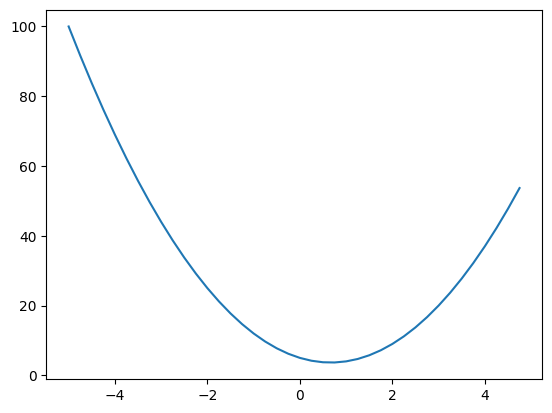

In [54]:
plt.plot(xs, ys)

In [55]:
h = 0.000001
x = 2/3

(f(x+h)-f(x))/h

2.999378523327323e-06

In [56]:
# lets get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c # this is a function/expression

print(d)


4.0


In [57]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0


# dd/da, derivative of "d" by wrt "a"
d1 = a*b + c
# bump a by h
a += h
d2 = a*b + c


print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [212]:
class Value:
    def __init__(self, data, _children = (), op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = op
        self.label = label
        self.grad = 0
        self._backprop = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        o = Value(self.data + other.data, (self, other), '+')
        def backprop():
            self.grad = 1 * o.grad
            other.grad = 1 * o.grad
        o._backprop = backprop

        return o

    def __mul__(self, other):
        o = Value(self.data * other.data, (self, other), '*')
        def backprop():
            self.grad = other.data * o.grad
            other.grad = self.data * o.grad
        o._backprop = backprop


        return o

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        o = Value(t, (self,), 'tanh')


        # chain-rule: self.grad * out.grad
        def backprop():
            self.grad = (1 - t**2) * o.grad

        o._backprop = backprop
        return o

    # only will be triggered by last node
    def backprop(self):
        self.grad = 1

        visited = set()
        topo = []
        def build_topo(node):

            #o(1) read
            if node in visited:
                return

            visited.add(node)
            for child in node._prev:
                build_topo(child)

            topo.append(node)

        build_topo(self)
        for node in reversed(topo):
            node._backprop()


a = Value(2.0 , label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
f = Value(-2.0, label = 'f')

e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
L = d*f; L.label = 'L'


In [36]:
from graphviz import Digraph

def trace(root):
    nodes = set()
    edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)

        for child in v._prev:
            edges.add((child, v))
            build(child)

        return nodes, edges

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

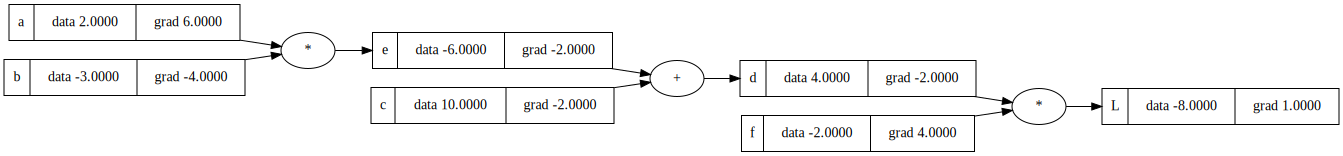

In [120]:
# base case
L.grad = 1

# manual back-propagation
L._backprop()
d._backprop()
e._backprop()

draw_dot(L)

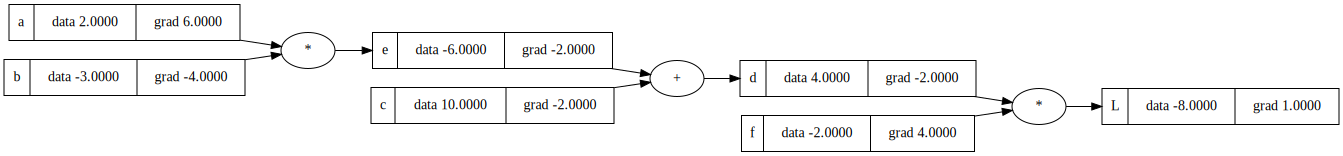

In [195]:
# base case
L.grad = 1

# auto back-propagation
visited = set()
topo = []
def build_topo(node):
    if node in visited:
        return

    visited.add(node)

    for child in node._prev:
        build_topo(child)

    topo.append(node)


build_topo(L)
for node in reversed(topo):
    node._backprop()
draw_dot(L)

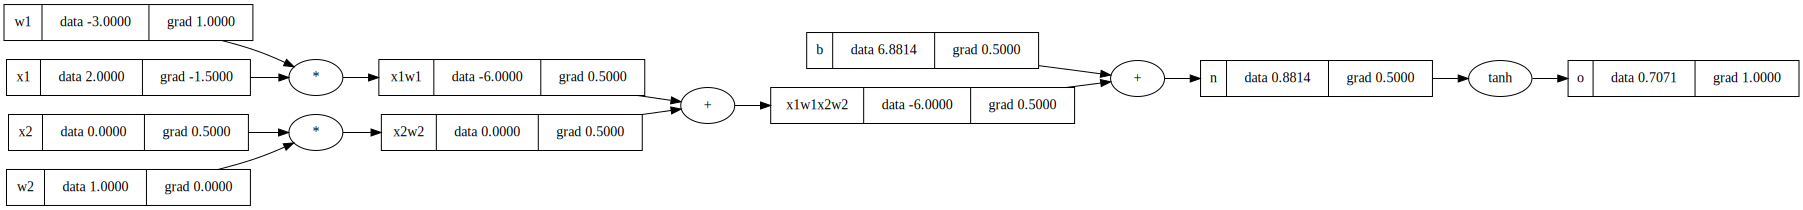

In [198]:
# neuron-network


x1 = Value(2.0, label ='x1')
x2 = Value(0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.881373587019542, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'

x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backprop()

draw_dot(o)

In [182]:
x = [1,2,3,4,5]
w = [1,2,3,4,5]

55

In [272]:
import torch

In [273]:
x1 = torch.tensor(2).double(); x1.requires_grad = True
x2 = torch.tensor(0).double(); x2.requires_grad = True
w1 = torch.tensor(-3).double(); w1.requires_grad = True
w2 = torch.tensor(1).double(); w2.requires_grad = True
b = torch.tensor(6.881373587019542).double(); b.requires_grad = True
n = (x1 * w1) + (x2 * w2) + b
o = n.tanh()

print('o.data', o.data.item())
print('x1.grad', x1.grad)
print(o.data.item())

o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

o.data 0.7071066904050358
x1.grad None
0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [274]:

print('rank 3 tensor, 3 dimension arrays of scalars, stacking 2D planes together')
rank_3_tensor = torch.tensor([
    # first 2D plane
    [
        [1,2],
        [2,3]
    ],
    # second 2D plane
    [
        [1,2],
        [2,3]
    ],
]).shape

print(rank_3_tensor)



print('---')
print('rank 4 tensor, 4 dimension arrays of scalars, stacking 3D cubes together')

rank_4_tensor = torch.tensor([
    # first 3D cube
    [
        # first 2D plane
        [
            [1,2],
            [2,3]
        ],
        # second 2D plane
        [
            [1,2],
            [2,3]
        ],
    ],
    # 2nd 3D cube
    [
        # first 2D plane
        [
            [1,2],
            [2,3]
        ],
        # second 2D plane
        [
            [1,2],
            [2,3]
        ],
    ],
]).shape

print(rank_4_tensor)

rank 3 tensor, 3 dimension arrays of scalars, stacking 2D planes together
torch.Size([2, 2, 2])
---
rank 4 tensor, 4 dimension arrays of scalars, stacking 3D cubes together
torch.Size([2, 2, 2, 2])


b Value(data=-0.7711329351942273)
w [Value(data=0.6210777366521096), Value(data=0.45114877524944785)]


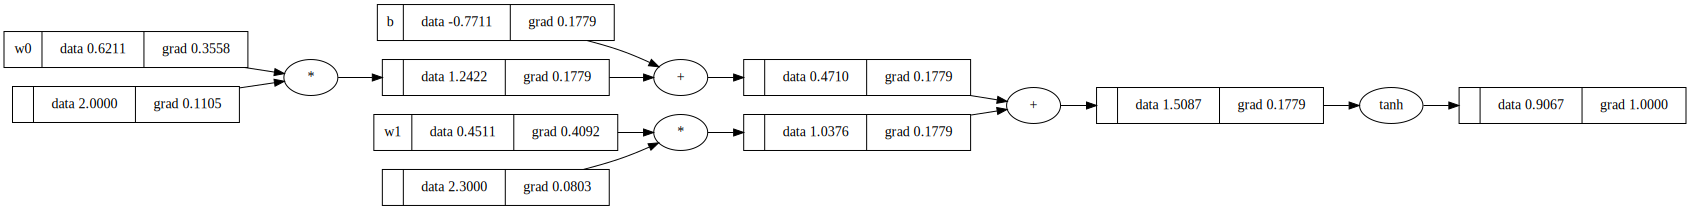

In [430]:
import random

class Neuron:
    # 1 neuron = 1 output
    # 1 neuron encapsulates 1 math-expression: act(Sum(x * w) + b)
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label ="w%s" % i) for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label = 'b')
        print('b', self.b)
        print('w', self.w)

    def __call__(self, x):
        # (w * x) + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

x = [Value(xi) for xi in [2.0, 2.3]]
n = Neuron(2)
k = n(x)
k.backprop()
draw_dot(k)


In [437]:
class Layer:
    # 1 layer = N outputs, aka 1 layer = nout
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [Value(xi) for xi in [2.0, 2.3]]
l = Layer(2, 3)
l(x)

b Value(data=0.5558582400829204)
w [Value(data=-0.56504875609603), Value(data=0.592950987261033)]
b Value(data=0.013876849906440114)
w [Value(data=-0.04156037096134502), Value(data=-0.4475853371740879)]
b Value(data=-0.8618973620595756)
w [Value(data=0.40120529682865924), Value(data=-0.8137886295155619)]


[Value(data=0.6581529020600213),
 Value(data=-0.8000280346387743),
 Value(data=-0.9588303400443562)]

b Value(data=0.44054420573379494)
w [Value(data=0.18167965026928723), Value(data=-0.1577080766715111)]
b Value(data=-0.29502407595014524)
w [Value(data=0.5354766621804048), Value(data=0.9310953804639766)]
b Value(data=0.17233929499180345)
w [Value(data=0.6216483298706568), Value(data=0.07416813988728532)]
b Value(data=0.7003349701386246)
w [Value(data=0.6364170741055977), Value(data=0.15282730438956693)]
b Value(data=-0.4939190156769684)
w [Value(data=-0.7000180098375985), Value(data=0.8711847778692063)]
b Value(data=-0.8711902271922387)
w [Value(data=-0.3406753922745762), Value(data=0.7092433125264963), Value(data=-0.7574735589957027)]


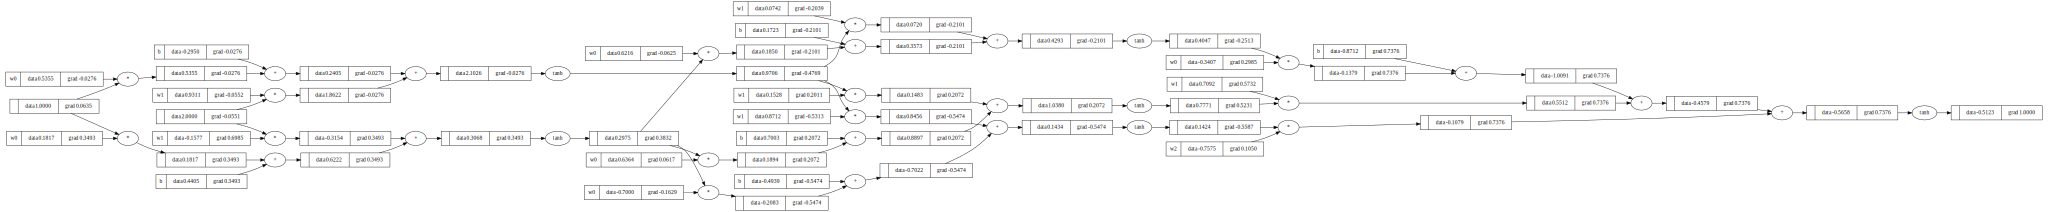

In [445]:
# MLP connected all the neourons together

# the output of the 1st layer, produces the input of the 2nd layer.
# the output of the N layer, produces the input of the N+1 layer.

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    # return output(s) of the last layer
    def __call__(self, x):
        x = [Value(xi) for xi in x]

        for layer in self.layers:
           x = layer(x)

        return x

x = [1.0, 2.0]
mlp = MLP(2, [2, 3, 1])
o = mlp(x)[0]
o.backprop()

draw_dot(o)